In [ ]:
import os
import numpy as np
import pandas as pd
import pwlf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from typing import Tuple, Optional, Dict, Any, List
from tabulate import tabulate


# ===============================
#   UTILS: resampling, smoothing, outlier removal
# ===============================

def resample_data(x: np.ndarray, y: np.ndarray, num_points: int = 200, deg: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """
    Ricampionamento usando fit polinomiale di grado `deg`.
    Restituisce x_new (velocità) e y_new (segnale ricampionati).
    """
    x = np.array(x)
    y = np.array(y)
    if len(x) < deg + 1:
        # fallback: semplice interp lineare
        x_new = np.linspace(x.min(), x.max(), num_points)
        y_new = np.interp(x_new, x, y)
        return x_new, y_new

    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    x_new = np.linspace(x.min(), x.max(), num_points)
    y_new = poly(x_new)
    return x_new, y_new

def apply_savgol(data: np.ndarray, window_length: Optional[int] = None, polyorder: int = 3) -> np.ndarray:
    """
    Applica filtro Savitzky-Golay. Sceglie una finestra valida (dispari e <= len(data)).
    Se len(data) < 5, ritorna i dati non filtrati.
    """
    n = len(data)
    if n < 5:
        return data.copy()
    if window_length is None:
        # scegliere una finestra ~ 1/15 della lunghezza, almeno 5
        wl = max(5, int(np.floor(n / 15)))
    else:
        wl = int(window_length)
    # assicurarsi sia dispari
    if wl % 2 == 0:
        wl += 1
    if wl >= n:
        wl = n - 1 if (n - 1) % 2 == 1 else n - 2
    if wl < 3:
        wl = 3
    try:
        return savgol_filter(data, window_length=wl, polyorder=polyorder)
    except Exception:
        # fallback safety
        return data.copy()

def paired_iqr_outlier_removal(x: np.ndarray, y: np.ndarray, k: float = 1.5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Rimuove coppie (x,y) dove y è outlier secondo IQR.
    Restituisce x_filtered, y_filtered (allineati).
    """
    y = np.array(y)
    x = np.array(x)
    if len(y) < 4:
        return x, y
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    mask = (y >= low) & (y <= high) & np.isfinite(y)
    return x[mask], y[mask]



# ===============================
#   CALCOLO SOGLIA (generico per un segnale vs speed)
# ===============================

def calculate_threshold_piecewise(signal: np.ndarray,
                                  speed: np.ndarray,
                                  num_points: int = 100,        # sempre 100
                                  poly_deg: int = 3,
                                  savgol_wl: Optional[int] = None,
                                  savgol_order: int = 3,
                                  skip_initial: int = 40,       
                                  iqr_k: float = 1.5,
                                  slope_change_required: Optional[float] = None,
                                  slope_direction: Optional[str] = None   # 'increase' o 'decrease'
                                  ) -> Tuple[Optional[float], Optional[float], Optional[int], Optional[Tuple[np.ndarray, np.ndarray, np.ndarray]], Optional[str]]:
    """
    Pipeline:
      - resample sempre a 100 punti
      - scarta sempre i primi N punti
      - savgol smoothing
      - paired outlier removal (IQR)
      - fit piecewise lineare
      - controllo pendenza se richiesto: aumento o diminuzione
    """
    try:
        sp_res, sig_res = resample_data(speed, signal, num_points=num_points, deg=poly_deg)
    except Exception as e:
        return None, None, None, None, f"Errore ricampionamento: {e}"

    # scarta i primi punti
    if len(sp_res) > skip_initial:
        sp_res = sp_res[skip_initial:]
        sig_res = sig_res[skip_initial:]

    # smoothing Savitzky-Golay
    sig_smooth = apply_savgol(sig_res, window_length=savgol_wl, polyorder=savgol_order)
    # paired outlier removal
    sp_filt, sig_filt = paired_iqr_outlier_removal(sp_res, sig_smooth, k=iqr_k)

    if len(sp_filt) < 8:
        return None, None, None, None, "Dati insufficienti dopo filtraggio/outlier removal"

    # Fit piecewise lineare
    try:
        pwlf_model = pwlf.PiecewiseLinFit(sp_filt, sig_filt)
        breaks = pwlf_model.fit(2)  # 2 segmenti → 1 breakpoint
        sig_fit = pwlf_model.predict(sp_filt)
        slopes = pwlf_model.calc_slopes()  # [slope1, slope2]
    except Exception as e:
        return None, None, None, None, f"Errore fit PWLF: {e}"

    # Controllo pendenza
    if slope_change_required is not None and slope_direction is not None:
        if len(slopes) < 2:
            return None, None, None, None, "Impossibile calcolare pendenze"
        if slope_direction == 'increase':
            # LACT: slope2 deve aumentare almeno del x% rispetto a slope1
            if slopes[1] < slopes[0] * (1.0 + slope_change_required):
                return None, None, None, None, f"Slope non aumenta di almeno {slope_change_required*100:.0f}% dopo breakpoint"
        elif slope_direction == 'decrease':
            # HR: slope2 deve diminuire almeno del x% rispetto a slope1, ma restare positiva
            if slopes[1] > slopes[0] * (1.0 - slope_change_required) or slopes[1] <= 0:
                return None, None, None, None, f"Slope non diminuisce di almeno {slope_change_required*100:.0f}% dopo breakpoint o diventa <=0"
        else:
            return None, None, None, None, "slope_direction deve essere 'increase' o 'decrease'"

    # threshold speed e segnale
    threshold_speed = breaks[1]
    try:
        threshold_signal = pwlf_model.predict([threshold_speed])[0]
    except Exception:
        threshold_signal = None

    idx = int(np.argmin(np.abs(sp_filt - threshold_speed)))

    return threshold_signal, threshold_speed, idx, (sp_filt, sig_filt, sig_fit), None

def speed_to_pace(speed_kmh):
    """Converte km/h in stringa mm:ss/km"""
    if speed_kmh is None or speed_kmh <= 0:
        return "N/A"
    total_min = 60 / speed_kmh
    minutes = int(total_min)
    seconds = int(round((total_min - minutes) * 60))
    return f"{minutes}:{seconds:02d} min/km"


# ===============================
#   MAIN: validate_conconi 
# ===============================

def validate_conconi(summary_file: str,
                     base_path: str,
                     save_plots: bool = True,
                     plots_folder_name: str = "plots"):
    os.makedirs(os.path.join(base_path, plots_folder_name), exist_ok=True)
    df_summary = pd.read_excel(summary_file)
    results = []

    for _, row in df_summary.iterrows():
        if 'sport' in row and str(row['sport']).lower() != 'running':
            continue

        athlete_file = os.path.join(base_path, row['file'])
        print(f"\nProcessing {athlete_file}")

        try:
            df_data = pd.read_excel(athlete_file, sheet_name="Sheet2")
        except Exception as e:
            print(f"Errore file {athlete_file}: {e}")
            continue

        available_cols = list(df_data.columns)
        speed_col_candidates = ['Actual Power', 'Speed', 'Velocità', 'Velocity', 'speed']
        hr_col_candidates = ['HR', 'HeartRate', 'heart_rate', 'hr']
        lact_col_candidates = ['Bla', 'Lactate', 'Lact', 'bLa', 'bla']

        def pick_col(cands, cols):
            for c in cands:
                if c in cols:
                    return c
            return None

        speed_col = pick_col(speed_col_candidates, available_cols)
        hr_col = pick_col(hr_col_candidates, available_cols)
        lact_col = pick_col(lact_col_candidates, available_cols)

        if speed_col is None or hr_col is None or lact_col is None:
            print(f"[WARN] Colonne mancanti in {athlete_file}. Trovate: {available_cols}")
            continue

        sp = pd.to_numeric(df_data[speed_col], errors='coerce').dropna().values
        hr = pd.to_numeric(df_data[hr_col], errors='coerce').dropna().values
        lact = pd.to_numeric(df_data[lact_col], errors='coerce').dropna().values

        if len(sp) < 6 or len(hr) < 6 or len(lact) < 6:
            print(f"[WARN] Dati troppo pochi in {athlete_file}. sp:{len(sp)}, hr:{len(hr)}, lact:{len(lact)}")
            continue

        # HR-based PWLF
        est_hr_val, est_sp_hr, idx_hr, debug_hr, warn_hr = calculate_threshold_piecewise(
            signal=hr, speed=sp, num_points=100, poly_deg=3, skip_initial=40,
            slope_change_required=0.10, slope_direction='decrease'
        )

        # LATTATO curve & automatic estimate (solo per fit/curve)
        est_lact_val_auto, est_sp_lact_auto, idx_lact_auto, debug_lact, warn_lact = calculate_threshold_piecewise(
            signal=lact, speed=sp, num_points=100, poly_deg=3, skip_initial=40,
            slope_change_required=0.30, slope_direction='increase'
        )

        # --- Lettura Sheet3 (Load @ Tlac, HR @ Tlac, BLA @ Tlac se presente) ---
        est_sp_lact_sheet = None      # Load @ Tlac (velocità)
        hr_at_tlac_sheet = None       # HR @ Tlac (bpm)
        bla_at_tlac_sheet = None      # Bla @ Tlac (mmol/L) -- nuovo campo

        try:
            df_sheet3 = pd.read_excel(athlete_file, sheet_name="Sheet3", header=None)
            sheet3_dict = dict(zip(df_sheet3.iloc[:, 0].astype(str).str.strip(), df_sheet3.iloc[:, 1]))
            # recupero con chiavi esatte
            load_tlac = sheet3_dict.get("Load @ Tlac", None)
            hr_tlac = sheet3_dict.get("HR @ Tlac", None)
            bla_tlac = sheet3_dict.get("Bla @ Tlac", sheet3_dict.get("Bla @ Tlac".strip(), None))
            # converti quando possibile
            try:
                est_sp_lact_sheet = float(load_tlac) if pd.notnull(load_tlac) else None
            except Exception:
                est_sp_lact_sheet = None
            try:
                hr_at_tlac_sheet = float(hr_tlac) if pd.notnull(hr_tlac) else None
            except Exception:
                hr_at_tlac_sheet = None
            try:
                bla_at_tlac_sheet = float(bla_tlac) if pd.notnull(bla_tlac) else None
            except Exception:
                bla_at_tlac_sheet = None
        except Exception as e:
            print(f"[WARN] Nessuna Sheet3 o errore lettura in {athlete_file}: {e}")

        # Usare est_sp_lact_sheet come soglia lact (velocità) se presente, altrimenti None
        est_sp_lact = est_sp_lact_sheet if est_sp_lact_sheet is not None else None
        # Per il valore di lattato da plottare: preferiamo Bla @ Tlac da Sheet3; fallback = valore stimato automaticamente dal fit (est_lact_val_auto)
        est_lact_val = None
        if bla_at_tlac_sheet is not None:
            est_lact_val = bla_at_tlac_sheet
        elif est_lact_val_auto is not None:
            est_lact_val = est_lact_val_auto
        else:
            est_lact_val = None

        # Calcolo HR interpolato alla velocità di soglia lattato (se possibile)
        hr_at_lact_speed = None
        hr_at_hr_speed = None
        if debug_hr is not None and est_sp_lact is not None:
            sp_hr_filt, hr_filt, hr_fit_line = debug_hr
            try:
                pw = pwlf.PiecewiseLinFit(sp_hr_filt, hr_filt)
                pw.fit(2)
                hr_at_lact_speed = float(pw.predict([est_sp_lact])[0])
                hr_at_hr_speed = float(pw.predict([est_sp_hr])[0]) if est_sp_hr is not None else None
            except Exception:
                try:
                    hr_at_lact_speed = np.interp(est_sp_lact, sp_hr_filt, hr_fit_line)
                    hr_at_hr_speed = np.interp(est_sp_hr, sp_hr_filt, hr_fit_line) if est_sp_hr is not None else None
                except Exception:
                    hr_at_lact_speed, hr_at_hr_speed = None, None

        # Confronti (restano invariati)
        err_speed = None
        err_hr = None
        if (est_sp_hr is not None) and (est_sp_lact is not None):
            err_speed = est_sp_hr - est_sp_lact
            if (est_hr_val is not None) and (hr_at_lact_speed is not None):
                err_hr = est_hr_val - hr_at_lact_speed
            elif (hr_at_hr_speed is not None) and (hr_at_lact_speed is not None):
                err_hr = hr_at_hr_speed - hr_at_lact_speed

        print(f"\nStimato HR-based: {est_sp_hr} km/h ({speed_to_pace(est_sp_hr)}), val segnale: {est_hr_val}")
        print(f"Letto LACT-based (Sheet3 Load @ Tlac): {est_sp_lact}, Bla@Tlac (sheet3): {bla_at_tlac_sheet}, HR@Tlac (sheet3): {hr_at_tlac_sheet}")

        # metriche e raccolta risultati (come prima)
        def speed_to_pace_sec(speed_kmh):
            if speed_kmh is None or speed_kmh <= 0:
                return np.nan
            return 3600 / speed_kmh

        pace_err_sec = None
        if (est_sp_hr is not None) and (est_sp_lact is not None):
            pace_err_sec = speed_to_pace_sec(est_sp_hr) - speed_to_pace_sec(est_sp_lact)

        results.append({
            "athlete_file": row['file'],
            "est_sp_hr": est_sp_hr,
            "est_hr_val": est_hr_val,
            "est_sp_lact": est_sp_lact,
            "est_lact_val": est_lact_val,
            "hr_at_lact_speed": hr_at_lact_speed,
            "err_sp_hr_minus_lact": err_speed,
            "err_hr_between_methods": err_hr,
            "err_pace_sec_per_km": pace_err_sec,
            "warn_hr": warn_hr,
            "warn_lact": warn_lact
        })

        # === Plot combinato e salvataggio ===
        if save_plots and debug_hr is not None and debug_lact is not None:
            try:
                plt.figure(figsize=(8, 5))
                ax1 = plt.gca()

                # --- HR-based (asse sinistro) ---
                sp_hr_plot, hr_plot, hr_fit_plot = debug_hr
                ax1.scatter(sp_hr_plot, hr_plot, marker='o', color='tab:red', label='HR misurata', alpha=0.6)
                ax1.plot(sp_hr_plot, hr_fit_plot, linestyle='-', linewidth=2, color='red', label='Fit HR (PWLF)')
                if est_sp_hr is not None and est_hr_val is not None:
                    ax1.scatter(est_sp_hr, est_hr_val, marker='X', s=100,
                                label='Soglia HR-based', color='darkred', zorder=6)

                ax1.set_xlabel("Velocità (km/h)")
                ax1.set_ylabel("Frequenza cardiaca (bpm)", color='tab:red')
                ax1.tick_params(axis='y', colors='tab:red')

                # --- Lattato-based (asse destro) ---
                ax2 = ax1.twinx()
                sp_l_plot, lact_plot, lact_fit_plot = debug_lact
                ax2.scatter(sp_l_plot, lact_plot, marker='s', color='tab:blue', label='Lattato misurato', alpha=0.6)
                ax2.plot(sp_l_plot, lact_fit_plot, linestyle='--', linewidth=2,
                         color='blue', label='Fit Lattato (PWLF)')

                # punto soglia lattato
                if est_sp_lact is not None and est_lact_val is not None:
                    ax2.scatter(est_sp_lact, est_lact_val, marker='D', s=100,
                                label='Soglia Lattato-based', color='navy', zorder=7)

                ax2.set_ylabel("Lattato (mmol/L)", color='tab:blue')
                ax2.tick_params(axis='y', colors='tab:blue')

                # --- HR interpolato alla velocità di soglia lattato (mostra solo se HR-based e Lattato-based sono separati) ---
                if hr_at_lact_speed is not None and est_sp_lact is not None:
                    ax1.scatter(est_sp_lact, hr_at_lact_speed, marker='^', s=80,
                                label='HR alla soglia lattato', color='orange', zorder=7)

                # --- legende e layout ---
                handles1, labels1 = ax1.get_legend_handles_labels()
                handles2, labels2 = ax2.get_legend_handles_labels()
                ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

                plt.title(f"Soglie HR e Lattato — {row['file']}")
                plt.grid(True)
                plt.tight_layout()

                # salvataggio
                athlete_name = os.path.splitext(os.path.basename(row['file']))[0]
                plot_path = os.path.join(base_path, plots_folder_name, f"soglie_{athlete_name}.png")
                plt.savefig(plot_path, dpi=300)
                print(f"Plot salvato: {plot_path}")

                # plt.show()
                plt.close()

            except Exception as e:
                print(f"[WARN] Errore nel plotting di {athlete_file}: {e}")


    # --- metrics aggregation (invariata) ---
    df_results = pd.DataFrame(results)
    for c in ['est_sp_hr','est_sp_lact','est_hr_val','est_lact_val','hr_at_lact_speed','err_sp_hr_minus_lact','err_hr_between_methods', 'err_pace_sec_per_km']:
        if c in df_results.columns:
            df_results[c] = pd.to_numeric(df_results[c], errors='coerce')

    def safe_mae(s): s=s.dropna(); return np.mean(np.abs(s)) if len(s) else np.nan
    def safe_mdae(s): s=s.dropna(); return np.median(np.abs(s)) if len(s) else np.nan
    def safe_me(s): s=s.dropna(); return np.mean(s) if len(s) else np.nan
    def safe_mde(s): s=s.dropna(); return np.median(s) if len(s) else np.nan

    metrics = {
        "N_tests": int(df_results.dropna(subset=['est_sp_hr','est_sp_lact']).shape[0]),
        "MAE_speed_between_methods_kmh": safe_mae(df_results['err_sp_hr_minus_lact']),
        "MDAE_speed_between_methods_kmh": safe_mdae(df_results['err_sp_hr_minus_lact']),
        "ME_speed_between_methods_kmh": safe_me(df_results['err_sp_hr_minus_lact']),
        "MDE_speed_between_methods_kmh": safe_mde(df_results['err_sp_hr_minus_lact']),
        "MAE_hr_between_methods_bpm": safe_mae(df_results['err_hr_between_methods']),
        "MDAE_hr_between_methods_bpm": safe_mdae(df_results['err_hr_between_methods']),
        "ME_hr_between_methods_bpm": safe_me(df_results['err_hr_between_methods']),
        "MDE_hr_between_methods_bpm": safe_mde(df_results['err_hr_between_methods']),
        "MAE_pace_between_methods_sec_per_km": safe_mae(df_results['err_pace_sec_per_km']),
        "MDAE_pace_between_methods_sec_per_km": safe_mdae(df_results['err_pace_sec_per_km']),
        "ME_pace_between_methods_sec_per_km": safe_me(df_results['err_pace_sec_per_km']),
        "MDE_pace_between_methods_sec_per_km": safe_mde(df_results['err_pace_sec_per_km']),
    }

    return df_results, metrics





summary_file = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\Data_Summary.xlsx"
base_path = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data"
results_df, metrics = validate_conconi(summary_file, base_path, save_plots=True)


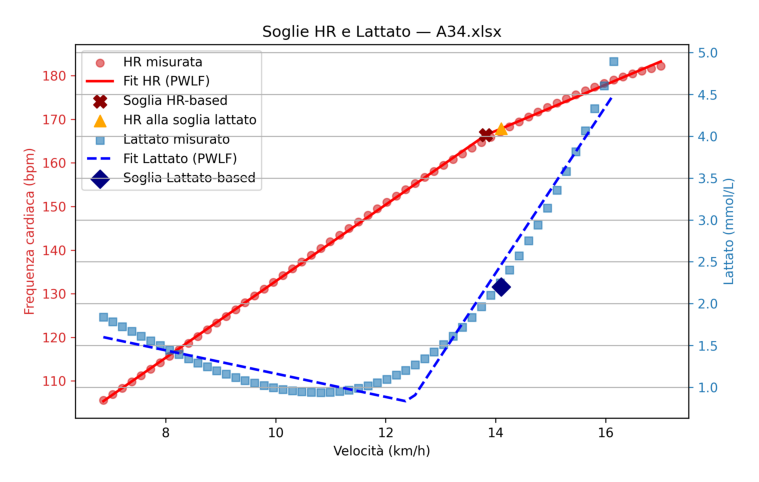

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorso dell'immagine salvata (modifica con il tuo file)
img_path = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\plots\soglie_A34.png"

# Lettura immagine
img = mpimg.imread(img_path)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')  # disabilita assi
plt.show()


In [ ]:
print("\n== Metriche aggregate ==")
table = [(k, v) for k, v in metrics.items()]
print(tabulate(table, headers=["Metrica", "Valore"], tablefmt="fancy_grid", floatfmt=".3f"))




== Metriche aggregate ==
╒══════════════════════════════════════╤══════════╕
│ Metrica                              │   Valore │
╞══════════════════════════════════════╪══════════╡
│ N_tests                              │  191.000 │
├──────────────────────────────────────┼──────────┤
│ MAE_speed_between_methods_kmh        │    2.080 │
├──────────────────────────────────────┼──────────┤
│ MDAE_speed_between_methods_kmh       │    1.299 │
├──────────────────────────────────────┼──────────┤
│ ME_speed_between_methods_kmh         │   -2.040 │
├──────────────────────────────────────┼──────────┤
│ MDE_speed_between_methods_kmh        │   -1.299 │
├──────────────────────────────────────┼──────────┤
│ MAE_hr_between_methods_bpm           │   11.599 │
├──────────────────────────────────────┼──────────┤
│ MDAE_hr_between_methods_bpm          │    6.811 │
├──────────────────────────────────────┼──────────┤
│ ME_hr_between_methods_bpm            │  -11.258 │
├─────────────────────────────────────